# Random Forest
Total dataset size: 134 samples <br>
Training set: 134 samples

Features used (after importance analysis):
- LTA precipitation (mmpa)
- LTA wet days
- LTA_PET_mm
- Aridity idx
- NDVI
- DEM
- LTA soil moisture - 10 cm (kg m-2) 

In [92]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
%matplotlib inline
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import rasterio
from utils import getAllCoordinates
import json

# Prepare all BGS points as training points

# read file (data + coordinates)
file = pd.read_csv('High_res_data_01/poc_01.csv')
# OMIT ZERO RECHARGE SAMPLES
file = file[file['Recharge_mmpa']!= 0.1]
#file = file[file['Recharge_mmpa']< 800]
# drop unimportant columns
data = file.drop(columns=['ID', 'Lat', 'Long', 'Landcover_ext', 'DEM'])
# Labels are the values we want to predict
labels = np.log10(data['Recharge_mmpa'])
data = data.drop('Recharge_mmpa', axis = 1)
# Add for reference
data['ID'] = file['ID']
# Saving feature names for later use
feature_list = list(data.columns)
# Convert to numpy array
features = np.array(data)

In [93]:
correlation_matrix = data.corr()
correlation_matrix

,LTA_CHIRPS_mmpa,LTA_PET_mm,Aridity,NDVI,SM10_m3m3,ID
LTA_CHIRPS_mmpa,1.000000,-0.702076,0.960139,0.800415,0.025803,0.000726
LTA_PET_mm,-0.702076,1.000000,-0.770768,-0.784442,0.121237,0.059164
Aridity,0.960139,-0.770768,1.000000,0.799033,-0.005604,-0.037322
NDVI,0.800415,-0.784442,0.799033,1.000000,0.068252,0.015778
SM10_m3m3,0.025803,0.121237,-0.005604,0.068252,1.000000,-0.037817
ID,0.000726,0.059164,-0.037322,0.015778,-0.037817,1.000000


# Run RF for the whole domain

### Find hyperparameters

In [104]:
from sklearn.model_selection import RandomizedSearchCV

estimator = RandomForestRegressor()
# Number of trees in random forest
n_estimators = [2000] * 10
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 0.33]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=estimator, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(features[:, :-1], labels)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 2000,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 60}

In [94]:
# get all coordinates of the smallest raster - workaround as rasters have slightly different shapes
coords, T0, out_shape = getAllCoordinates('High_res_data_01/NDVI_Afr_01.tif', grid=0.1)

In [95]:
# read rasters
pet_src = rasterio.open('High_res_data_01/LTA_PET_Afr_01.tif')
p_src = rasterio.open('High_res_data_01/LTA_CHIRPS_clipped_01.tif')
ndvi_src = rasterio.open('High_res_data_01/NDVI_Afr_01.tif')
ai_src = rasterio.open('High_res_data_01/LTA_AI_Afr_01_scaled.tif')
sm_src = rasterio.open('High_res_data_01/Soil_moisture_Afr_01.tif')

# get raster values at 0.5x0.5 grid + flatten
pet_samples = [item for sublist in list(pet_src.sample(coords)) for item in sublist]
p_samples = [item for sublist in list(p_src.sample(coords)) for item in sublist]
ndvi_samples = [item for sublist in list(ndvi_src.sample(coords)) for item in sublist]
ai_samples = [item/10000 for sublist in list(ai_src.sample(coords)) for item in sublist]
sm_samples = [item for sublist in list(sm_src.sample(coords)) for item in sublist]

KeyboardInterrupt: 

In [152]:
[item for sublist in list(sm_src.sample([(27.1447, -25.9933)])) for item in sublist]

[0.2495819]

In [105]:
# combine predictors in a dataframe
raw_ds = pd.DataFrame({'LTA_CHIRPS_mmpa': p_samples, 'LTA_PET_mm': pet_samples, 'Aridity': ai_samples, 
                       'NDVI': ndvi_samples, 
                       'SM10_m3m3': sm_samples, 
                      })

# take rows with valid predictor data (land only)
filtered_ds = raw_ds[(raw_ds['LTA_CHIRPS_mmpa'] >= 0) & (raw_ds['LTA_PET_mm'] >= -1000) 
                     & (raw_ds['Aridity'] >= -1000) & (raw_ds['NDVI'] >= -1000) 
                     & (raw_ds['SM10_m3m3'] > 0)]

# convert dataframe to numpy array
domain_features = np.array(filtered_ds)

params = {'n_estimators': 2000,
         'min_samples_split': 15,
         'min_samples_leaf': 1,
         'max_features': 'auto',
         'max_depth': 60,
         'bootstrap': True}

# instantiate random forest model
final_rf = RandomForestRegressor(**params, oob_score=True)

In [106]:
# train the model on entire BGS dataset
final_rf.fit(features[:,:-1], labels)
# use the forest's predict method on the whole domain
pred_recharge = final_rf.predict(domain_features)
# apply to training set again
train_predictions = final_rf.predict(features[:,:-1])

In [107]:
print(f'OOB score {final_rf.oob_score_}')

OOB score 0.6605295472515099


In [108]:
# merge with the features dataframe and back transform
filtered_ds['pred_recharge_mmpa'] = 10**pred_recharge
# fill gaps in the dataframe - revert to 0.1x0.1 grid
reindx_ds = filtered_ds.reindex(range(len(raw_ds)), fill_value=-9999)
recharge_grid = np.array(reindx_ds['pred_recharge_mmpa']).reshape(out_shape)

# attempt to save to a raster
# config
out_meta = {'driver': 'GTiff', "dtype": 'float32', "height": recharge_grid.shape[0], "width": recharge_grid.shape[1],
            "count": 1, "transform": T0, 'nodata': -9999, 'crs': rasterio.crs.CRS({"init": "epsg:4326"})}

# save
with rasterio.open("High_res_data_01/RF_recharge_01.tif", "w", **out_meta) as dest:
    dest.write(recharge_grid[np.newaxis, :, :])

In [109]:
# Get numerical feature importances
importances = list(final_rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most Aimportant first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: SM10_m3m3            Importance: 0.42
Variable: LTA_CHIRPS_mmpa      Importance: 0.31
Variable: Aridity              Importance: 0.2
Variable: NDVI                 Importance: 0.05
Variable: LTA_PET_mm           Importance: 0.02


In [110]:
10**np.max(pred_recharge)

281.2224758064236

In [111]:
# compare BGS linear model and random forest
point_coords = [(i,j) for (i,j) in zip(file['Long'], file['Lat'])]
obs = file['Recharge_mmpa']
rf_rech_src = rasterio.open('High_res_data_01/RF_recharge_01.tif')
bgs_rech_src = rasterio.open('139265/Africa_Recharge_Map/Africa_recharge.tif')
rf_rech_samples = [item for sublist in list(rf_rech_src.sample(point_coords, indexes=1)) for item in sublist]
bgs_rech_samples = [item for sublist in list(bgs_rech_src.sample(point_coords)) for item in sublist]

summary = pd.DataFrame({'Coords': point_coords, 'Observations': obs, 'RF recharge': rf_rech_samples, 
              'BGS recharge': bgs_rech_samples})

print(summary)

              Coords  Observations  RF recharge  BGS recharge
0       (4.48, 8.49)         253.0   199.785324    139.130249
1    (30.09, -20.27)          22.0    20.758734     25.397594
2      (32.96, 0.46)         245.0   196.980682    133.193283
3     (39.82, 13.54)         185.0    71.827690     63.007080
4         (2.3, 6.5)         120.0   187.392258    125.447845
..               ...           ...          ...           ...
129    (27.7, -26.0)         100.0    81.264709     39.552135
130  (30.55, -17.71)          80.0    67.540504     59.158382
131   (-17.0, 14.72)           8.0    10.407059     20.644716
132     (38.64, 9.4)         160.0   108.369766    141.219238
133   (33.74, -5.96)          41.0    63.051952     42.370590

[127 rows x 4 columns]


In [113]:
# problem: some observations are outside of the domain!
print(summary[(summary['BGS recharge'] < 0) | (summary['RF recharge'] < 0)])
# ignore these point for now
summary = summary[(summary['BGS recharge'] >= 0) & (summary['RF recharge'] >= 0)]
print('BGS vs obs R^2:', metrics.r2_score(summary['Observations'], summary['BGS recharge']))
print('RF vs obs R^2:', metrics.r2_score(summary['Observations'], summary['RF recharge']))
print('RF vs BGS R^2:', metrics.r2_score(summary['RF recharge'], summary['BGS recharge']))

Empty DataFrame
Columns: [Coords, Observations, RF recharge, BGS recharge]
Index: []
BGS vs obs R^2: 0.49735709640811243
RF vs obs R^2: 0.5288906656551365
RF vs BGS R^2: 0.8261767688880194


(0.0, 1000.0)

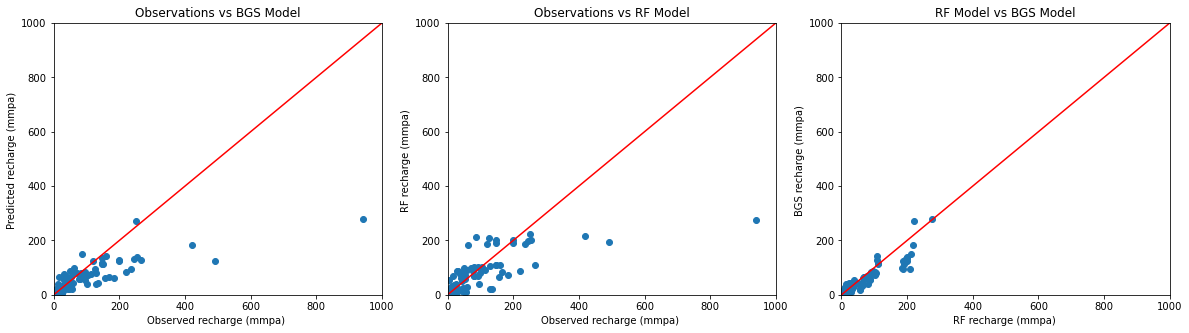

In [114]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
axs = axs.flatten()
axs[0].plot(summary['Observations'], summary['BGS recharge'],marker='o',linestyle='')
axs[0].plot(range(0,1000), range(0,1000), 'r')
axs[0].set_xlabel('Observed recharge (mmpa) ')
axs[0].set_ylabel('Predicted recharge (mmpa) ')
axs[0].set_xlim([0,1000])
axs[0].set_title('Observations vs BGS Model')
axs[0].set_ylim([0,1000])

axs[1].plot(summary['Observations'], summary['RF recharge'],marker='o',linestyle='')
axs[1].plot(range(0,1000), range(0,1000), 'r')
axs[1].set_xlabel('Observed recharge (mmpa) ')
axs[1].set_ylabel('RF recharge (mmpa) ')
axs[1].set_xlim([0,1000])
axs[1].set_title('Observations vs RF Model')
axs[1].set_ylim([0,1000])

axs[2].plot(summary['RF recharge'], summary['BGS recharge'],marker='o',linestyle='')
axs[2].plot(range(0,1000), range(0,1000), 'r')
axs[2].set_xlabel('RF recharge (mmpa) ')
axs[2].set_ylabel('BGS recharge (mmpa) ')
axs[2].set_xlim([0,1000])
axs[2].set_title('RF Model vs BGS Model')
axs[2].set_ylim([0,1000])

# Visualise

In [143]:
import geemap
import ee
ee.Initialize()

# center over Africa
Map = geemap.Map(center=[0,40], zoom=2)

# add BGS recharge to the map
bgs_recharge_vis_params = {
    'min': 0,'max': 300, 
    'bands':'bgs_recharge', 'palette': ['red', 'pink', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue']
}
ee_bgs_recharge = ee.Image('users/pazolka/BGS_Africa_recharge').rename('bgs_recharge')
Map.addLayer(ee_bgs_recharge, bgs_recharge_vis_params, 'BGS recharge', shown=False)
# fix for clean colorbar
bgs_recharge_vis_params['bands'] = 'BGS recharge (mmpa)'
Map.add_colorbar(bgs_recharge_vis_params)

In [149]:
# visualise RF results
#Map.add_raster('RF_recharge.tif', colormap='RdYlGn', bands=[1], layer_name='RF recharge')
# add GEE for seamless inspection
rf_recharge_vis_params = {
    'min': 0,'max': 300, 
    'bands':'rf_recharge', 'palette': ['red', 'pink', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue']
}
ee_rf_recharge = ee.Image('users/pazolka/RF_recharge_01').rename('rf_recharge')
ee_rf_recharge_05 = ee.Image('users/pazolka/RF_recharge').rename('rf_recharge')

Map.addLayer(ee_rf_recharge_05, rf_recharge_vis_params, 'RF recharge 05', shown=False)
Map.addLayer(ee_rf_recharge, rf_recharge_vis_params, 'RF recharge', shown=False)

# fix for clean colorbar
rf_recharge_vis_params['bands'] = 'RF recharge (mmpa)'
Map.add_colorbar(rf_recharge_vis_params)

In [145]:
Map.add_raster('High_res_data_01/Soil_moisture_Afr_01.tif', colormap='Spectral', bands=[1], layer_name='sm')

In [146]:
Map.add_raster('High_res_data_01/landcover_Afr_01.tif', colormap='Spectral', bands=[1], layer_name='lc')

In [138]:
Map.add_raster('High_res_data_01/LTA_CHIRPS_clipped_01.tif', colormap='Spectral', bands=[1], layer_name='pcp')

In [137]:
Map.add_raster('High_res_data_01/DEM_Afr_01.tif', colormap='Spectral', bands=[1], layer_name='dem')

In [142]:
Map.add_raster('High_res_data_01/NDVI_Afr_01.tif', colormap='Spectral', bands=[1], layer_name='ndvi')

In [139]:
Map.add_raster('High_res_data_01/LTA_AI_Afr_01_scaled.tif', colormap='Spectral', bands=[1], layer_name='ai')

In [140]:
Map.add_raster('High_res_data_01/LTA_PET_Afr_01.tif', colormap='Spectral', bands=[1], layer_name='pet')

In [22]:
Map.add_raster('High_res_data_01/RF_recharge_01.tif', colormap='Spectral', bands=[1], layer_name='rf')

In [150]:
Map

Map(bottom=37889.0, center=[-25.58703983205006, 25.903015136718754], controls=(WidgetControl(options=['positio…

In [148]:
Map.add_shapefile("CRU_precip_CGIAR_AI_data/Africa_continent_shape.shp", style={"weight": 2, 'fill':False}, fill_colors=['white'], info_mode='on_hover')